## Tutorial: Content Embedding and Retrieval

#### Objective
- Understand the role of embeddings in capturing semantic relationships between content.
- Generate embeddings for textual data using pre-trained LLMs.
- Perform content retrieval using Approximate Nearest Neighbor (ANN) search with these embeddings.

In [22]:
pip install faiss-cpu
pip install numpy scikit-learn bm25s

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


#### Step 1: Understanding Content Embedding
Content embedding is the process of transforming input data (e.g., text, images) into dense vectors that capture semantic meaning. These embeddings are essential for tasks like:

- Similarity Search: Finding similar items based on their embeddings.
- Recommendation: Matching user preferences with item embeddings.


In [23]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained model and tokenizer
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embeddings(texts, model, tokenizer):
    """
    Generate dense embeddings for a list of texts using a pre-trained model.
    """
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Average pooling of the last hidden states
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings

# Example texts
texts = ["I love machine learning.", "Transformers are powerful.", "Embeddings capture meaning."]
embeddings = generate_embeddings(texts, model, tokenizer)
print("Embeddings shape:", embeddings.shape)


Embeddings shape: torch.Size([3, 384])


#### Step 4: Visualizing Embeddings

Visualizing embeddings can help understand how content is semantically clustered.

**Code: 2D Visualization with t-SNE**

Number of samples: 3
Using perplexity: 2


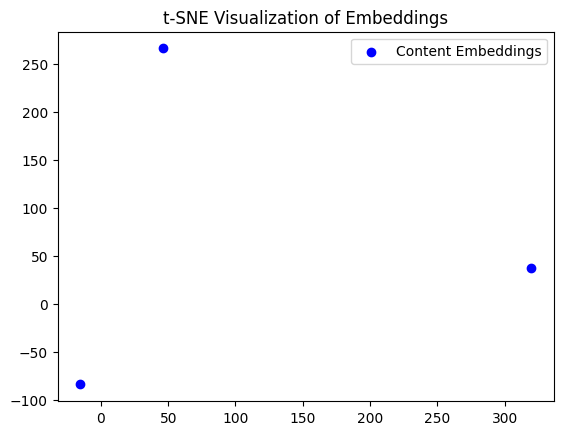

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume embeddings_np is a NumPy array of embeddings
print(f"Number of samples: {embeddings_np.shape[0]}")

# Set perplexity dynamically
perplexity = min(30, embeddings_np.shape[0] - 1)
print(f"Using perplexity: {perplexity}")

# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', label='Content Embeddings')
plt.title("t-SNE Visualization of Embeddings")
plt.legend()
plt.show()


#### Step 3: Content Retrieval Using ANN

To retrieve content efficiently, we’ll use Approximate Nearest Neighbor (ANN) techniques, leveraging libraries like FAISS.

- BM25 retrieval.
- Hybrid retrieval.
- Hybrid retrieval with document expansion.

In [26]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import bm25s

# Sample corpus for demonstration
corpus = [
    "a cat is a feline and likes to purr",
    "a dog is the human's best friend and loves to play",
    "a bird is a beautiful animal that can fly",
    "a fish is a creature that lives in water and swims"
]

# Initialize BM25 model
bm25_retriever = bm25s.BM25(corpus)

def bm25_retrieve(query, k=2):
    """Retrieve top k documents using BM25."""
    results, scores = bm25_retriever.retrieve(bm25s.tokenize(query), k=k)
    return results, scores

def embedding_retrieve(query_embedding, document_embeddings, k=2):
    """Retrieve top k documents based on embedding similarity."""
    similarities = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)
    top_k_indices = similarities.argsort()[0][-k:][::-1]
    return top_k_indices, similarities[0][top_k_indices]

def hybrid_retrieve(query_embedding, document_embeddings, query, k=2):
    """Hybrid retrieval combining BM25 and embedding-based methods."""
    # Get BM25 results
    bm25_results, _ = bm25_retrieve(query, k)
    
    # Get embedding results
    embedding_indices, _ = embedding_retrieve(query_embedding, document_embeddings, k)
    
    # Combine results (you can customize the combination logic)
    combined_results = set(bm25_results) | set(np.array(corpus)[embedding_indices])
    
    return list(combined_results)

# Example usage:
query_text = "What animal likes to purr?"
query_embedding = np.random.rand(300)  # Replace with actual query embedding generation
document_embeddings = np.random.rand(len(corpus), 300)  # Replace with actual document embeddings

# Retrieve using BM25
bm25_results, bm25_scores = bm25_retrieve(query_text)
print("BM25 Results:", bm25_results)

# Retrieve using Embedding-Based Retrieval
embedding_indices, embedding_scores = embedding_retrieve(query_embedding, document_embeddings)
print("Embedding Results:", np.array(corpus)[embedding_indices])

# Retrieve using Hybrid Method
hybrid_results = hybrid_retrieve(query_embedding, document_embeddings, query_text)
print("Hybrid Results:", hybrid_results)


Recommendations: ['AI trends in 2024.', 'Machine learning basics.', 'Deep learning applications.']


#### Step 4: Evaluating Retrieval
To assess the performance:

1. Use a metric like Precision@K: How many retrieved items are relevant?
2. Create labeled test sets with query-relevant pairs.

**Code: Precision@K**

In [27]:
def evaluate_retrieval(retrieved_results, relevant_documents):
    """Evaluate retrieval performance based on relevant documents."""
    retrieved_set = set(retrieved_results)
    relevant_set = set(relevant_documents)
    
    true_positives = len(retrieved_set & relevant_set)
    precision = true_positives / len(retrieved_set) if retrieved_set else 0
    recall = true_positives / len(relevant_set) if relevant_set else 0
    
    return precision, recall

# Define some relevant documents for evaluation (ground truth)
relevant_documents = ["a cat is a feline and likes to purr", "a dog is the human's best friend and loves to play"]

# Evaluate each method
bm25_precision, bm25_recall = evaluate_retrieval(bm25_results, relevant_documents)
embedding_precision, embedding_recall = evaluate_retrieval(np.array(corpus)[embedding_indices], relevant_documents)
hybrid_precision, hybrid_recall = evaluate_retrieval(hybrid_results, relevant_documents)

print("BM25 Precision:", bm25_precision, "Recall:", bm25_recall)
print("Embedding Precision:", embedding_precision, "Recall:", embedding_recall)
print("Hybrid Precision:", hybrid_precision, "Recall:", hybrid_recall)


Precision@2: 0.5
